## Group No 228

## Group Member Names:
1. Bhavuk Sagar
2. Harsh Raj
3. NANDIMATH POOJA SHIVAKUMAR

### Task:- Video Classification using CNN+LSTM

• Dataset : UCF-101 Dataset
     https://www.crcv.ucf.edu/data/UCF101.phpLinks to an external site.

• Encoder is a CNN. The input image is given to CNN to extract the features. The last hidden state of the CNN is connected to the Decoder.</br>
• Decoder is LSTM. The first time step receives the encoded output from the encoder and also the START vector.

### 1. Import Libraries/Dataset
#### a. Import the required libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import os
import cv2
import random
import time
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.applications import VGG16,ResNet50,Xception
from tensorflow.keras.layers import TimeDistributed,LSTM,Input,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

#### b. Check the GPU available

In [3]:
#checking GPU availability
if tf.test.gpu_device_name():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [5]:
#from the whole dataset we are selecting top 5 classes
path="/content/drive/MyDrive/UCF101/"
top_5=os.listdir(path)[1:6]
top_5

['RockClimbingIndoor',
 'FieldHockeyPenalty',
 'PlayingViolin',
 'ApplyLipstick',
 'HorseRace']

### 2. Data Processing
#### a. Plot at least two samples and their captions

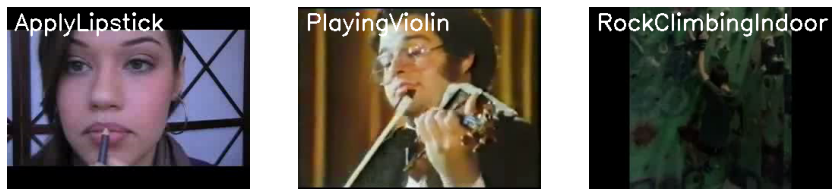

In [6]:
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories.
all_classes_names = top_5
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)),3)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/UCF101/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/UCF101/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

#### b. Convert the data into the correct format which could be used for the DL model.

In [7]:
#setting the frame height,width and no. of frame which we are going to use from each video
height=128
width=128
frames_for_model=15

In [8]:
#function for loading the labels and video path from the folder
def loading_data_folders(path):
    videos_name=[]
    labels_name=[]
    
    for lab in top_5:
        for video in os.listdir(path+lab):
            videos_name.append(path+"/"+lab+"/"+video)
            labels_name.append(lab)
            
    return np.array(videos_name),np.array(labels_name)


#function for normalizing the frames of the video
def video_processing(frames):
    frames=cv2.resize(frames,(width,height)) # resizing the frame size
    frames=frames/255 #changing the range of pixel value in b/w 0 to 1
    
    return frames


# Selecting the specific frames from the whole video for processing
def select_frame(video_frame):
    selected_frames = []
    if len(video_frame)> frames_for_model:
        fn=len(video_frame)//frames_for_model
        f_num=0
        
        for f in video_frame:
            if len(selected_frames)<frames_for_model:
                if f_num % fn == 0:
                    selected_frames.append(f)
            f_num+=1
    else:
        selected_frames=video_frame
    return selected_frames


# function for loading the video from the folder and processing it.
def load_video_and_process(video_path):
    load_frame=[]
    
    cap=cv2.VideoCapture(video_path) #reading the video
    while True:
        ret,frame=cap.read()
        if ret == True:
            load_frame.append(video_processing(frame)) #processing the each frame
        else:
            break
    cap.release()
    load_frame=select_frame(load_frame) #selecting the specific frames
        
    return np.array(load_frame) #returning the video in array format suitable for model
        
        

In [9]:
def create_dataset(file_name,tag_name,indx):
    x=[]
    y=[]
    for video,label in zip(file_name[indx],tag_name[indx]):
        x.append(load_video_and_process(video))
        y.append(label)
        
    return np.array(x),np.array(y)

In [90]:
# function for encoding the lables
def encode_lable(tags):
    le=LabelEncoder()
    le.fit(np.unique(tags))
    encoded_labels=le.transform(tags)
    encoded_labels=np.reshape(encoded_labels,(-1,1))
    encoder=OneHotEncoder()             #converting the labels in onehotencoding
    encoder.fit(encoded_labels)
    encoded_labels=encoder.transform(encoded_labels)
    encoded_labels=encoded_labels.toarray()
    return encoded_labels

In [11]:
#calling functions for creating dataset
videos,labels=loading_data_folders(path) #loading labels and video names from the folder
encoded_labels_for_model=encode_lable(labels) #encoding the labels
index=list(range(len(videos))) 
np.random.shuffle(index)         #shuffling the data
x,y=create_dataset(videos,encoded_labels_for_model,index) #creating the dataset in X and Y format (array)

In [12]:
#garbage collector for cleaning the ram
gc.collect()


9196

#### c. Load the data into train and test data in the required format.

In [42]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=25) #spliting the data in test and train

In [14]:
print("No. of Sample for training:",x_train.shape[0])
print("No. of Sample for testing:",x_test.shape[0])

No. of Sample for training: 456
No. of Sample for testing: 152


### 3. Model Building 
#### a. Use any pre-trained model trained on ImageNet dataset (available publicly on Google) for image feature extraction.

In [15]:
#pretrained model with imageNet dataset weights for image feature extraction
base=ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))
base.trainableb=False

In [16]:
#extraction model summary 
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

#### b.  Create k-layered LSTM model and other relevant layers.
#### b.  Create k-layered LSTM model and other relevant layers.
#### c. Add one layer of dropout at the appropriate position and give reasons.
#### d .Choose the appropriate activation function for all the layers.

In [50]:
#Model building
model = Sequential()
model.add(TimeDistributed(base))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(.10)) # dropout layer with 10% rate
model.add(LSTM(45, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))#output layer with 5 units.

In [51]:
#hyperparameter tuning
early=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

#### e. Justify the choice of number of layers, activation function and any other hyper parameters used.
-> The model architecture consists of five layers:

1. A TimeDistributed layer that applies the base layer to each time step of the input sequence. This is useful when dealing with sequential data such as time series or videos.
2. Another TimeDistributed layer with a Flatten() layer as its input. This layer flattens the output of the previous layer, which can then be fed into a non-sequential layer.
3. An LSTM layer with 45 units. LSTMs are a type of recurrent neural network (RNN) commonly used for processing sequential data. The number of units in the layer determines the complexity of the LSTM's internal representation.
4. A Dropout layer with a rate of 10%. Dropout is a regularization technique used to prevent overfitting by randomly dropping out some of the neurons during training.
5. A Dense layer with a softmax activation function. This layer produces the output of the model, which is a probability distribution over the classes. The number of neurons in this layer is equal to the number of unique labels in the dataset.

-> Activation Function:</br>
* We are using softmax activation function in output layer because our model is catergorical classification model and having 5 classes.

-> Hyperparameter tuning and optimization:
* We are using erlystopping concept in out model for optimization. EarlyStopping is a commonly used callback in deep learning to prevent overfitting and stop training the model when the performance on the validation set stops improving.


### 4.Model Compilation 
• Compile the model with the appropriate loss function.</br>
• Use an appropriate optimizer.</br>
• Justify the choice of learning rate, optimizer, loss function and any other hyper parameter used.</br>

In [52]:
#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics='accuracy')

#### Summary
-> loss='categorical_crossentropy': This specifies the loss function to be used during training. In this case, it is categorical cross-entropy, which is commonly used for multi-class classification problems where the output is a probability distribution over multiple classes.</br></br>
-> optimizer='adam': This specifies the optimization algorithm to be used during training. In this case, it is the Adam optimizer, which is an adaptive learning rate optimization algorithm that is commonly used for deep learning models.</br></br>
-> metrics='accuracy': This specifies the evaluation metric to be used during training and testing. In this case, it is the accuracy metric, which measures the percentage of correctly classified samples.</br></br>

### 5. Model Training
• Train the model for an appropriate number of epochs.</br>
• Print the train and validation loss for each epoch. Use the appropriate batch size.</br>
• Print the total time taken for training.

In [53]:
start = time.time() #starting the time
history=model.fit(x_train,y_train,epochs=20,validation_split=0.20,batch_size=50,callbacks=early) #fitting the model with required parameters
end = time.time() #stopping the time 
print("Time Taken:",end - start)

Epoch 1/20
8/8 [==============================] - 50s 814ms/step - loss: 31.3833 - accuracy: 0.2967 - val_loss: 314.2093 - val_accuracy: 0.3152
Epoch 2/20
8/8 [==============================] - 4s 464ms/step - loss: 9.1838 - accuracy: 0.4588 - val_loss: 260.1558 - val_accuracy: 0.3696
Epoch 3/20
8/8 [==============================] - 4s 464ms/step - loss: 9.0884 - accuracy: 0.3516 - val_loss: 7.9470 - val_accuracy: 0.3804
Epoch 4/20
8/8 [==============================] - 4s 464ms/step - loss: 3.3947 - accuracy: 0.4093 - val_loss: 13.2115 - val_accuracy: 0.4457
Epoch 5/20
8/8 [==============================] - 4s 462ms/step - loss: 4.7589 - accuracy: 0.4011 - val_loss: 12.0377 - val_accuracy: 0.4239
Epoch 6/20
8/8 [==============================] - 4s 464ms/step - loss: 3.3077 - accuracy: 0.5082 - val_loss: 2.9166 - val_accuracy: 0.4565
Epoch 7/20
8/8 [==============================] - 4s 467ms/step - loss: 1.5673 - accuracy: 0.4753 - val_loss: 24.5205 - val_accuracy: 0.3261
Epoch 8/20


In [54]:
#summary of the model
model.summary() 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 15, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 32768)        0         
 stributed)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 15, 32768)         0         
                                                                 
 lstm_5 (LSTM)               (None, 45)                5906520   
                                                                 
 dense_5 (Dense)             (None, 5)                 230       
                                                                 
Total params: 29,494,462
Trainable params: 29,441,342


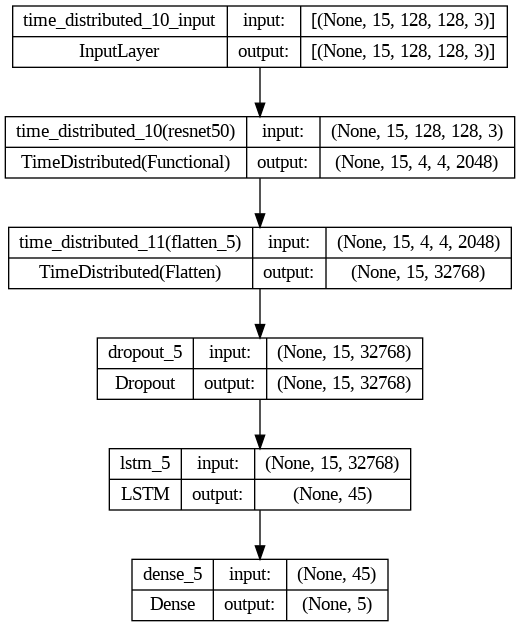

In [55]:
# Plot the structure of the contructed model.
plot_model(model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#### • Plot the loss and accuracy history graphs for both train and validation set.

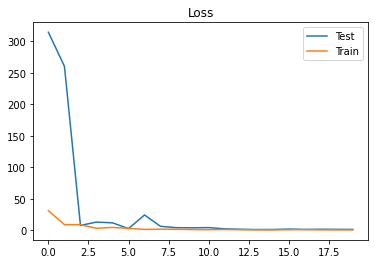

In [58]:
#plotting the chart of the accuracy
plt.title("Loss")
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.legend(("Test","Train"))

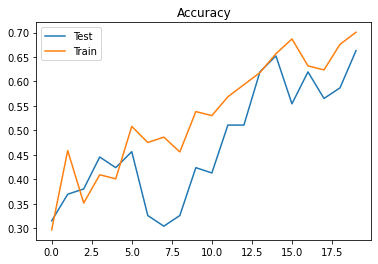

In [59]:
#plotting the chart of the accuracy
plt.title("Accuracy")
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.legend(("Test","Train"))


### 6. Model Evaluation
 Take 5 random data from the test set and perform activity recognition

In [93]:
#prediciting on random 5 test data
y_pred=model.predict(x_test)

dec={0:'RockClimbingIndoor',1:'FieldHockeyPenalty',2:'PlayingViolin',3:'ApplyLipstick',4:'HorseRace'}
for i in range(1,6):
  tem=np.argmax(y_pred[i])
  print(f"Prediction of sample {i}:",dec[tem]) 

5/5 [==============================] - 0s 83ms/step
Prediction of sample 1: RockClimbingIndoor
Prediction of sample 2: PlayingViolin
Prediction of sample 3: HorseRace
Prediction of sample 4: HorseRace
Prediction of sample 5: PlayingViolin


#### * Print confusion metrics and classification report for the test data.

In [104]:
print("Confusion Metrics:")
pred=[]
for i in y_pred:
  pred.append(np.argmax(i))
enc = tf.argmax(y_test, axis = 1)

print(confusion_matrix(pred,enc),end="\n\n\n")

print("Classification Report:")

print(classification_report(pred,enc))

Confusion Metrics:
[[18  2  0  2  4]
 [ 4 17  1  1  3]
 [ 0  5 22  1  1]
 [ 5  8  1 13  1]
 [ 5  1  5  9 23]]


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62        26
           1       0.52      0.65      0.58        26
           2       0.76      0.76      0.76        29
           3       0.50      0.46      0.48        28
           4       0.72      0.53      0.61        43

    accuracy                           0.61       152
   macro avg       0.61      0.62      0.61       152
weighted avg       0.62      0.61      0.61       152

